In this notebook, we are looking at the paper:

*   Harrison, Willes, Snoek: Variational Bayesian Last Layers. 2024, [ 	arXiv:2404.11599](https://arxiv.org/pdf/2404.11599)

We will study the VBBL model next to a Monte-Carlo dropout (MC dropout) model to see what effect the introduction of VBBL has on predictions and their uncertainties.

Specifically, we will use the TissueMNIST dataset (from the [MedMNIST](https://medmnist.com/)) as our playground.

In [1]:
!pip install pytorch_lightning
!pip install vbll

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 43.2 MB/s eta 0:00:00


The dataset can be downloaded from https://zenodo.org/records/10519652 but I will access it from Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

!cp -r drive/MyDrive/tissuemnist_64.npz /content/tissuemnist_64.npz

Mounted at /content/drive


After importing libraries, let's set some defaults and hyperparameters:

In [3]:
from abc import ABC, abstractmethod
from copy import deepcopy
from functools import partial
import gc
import numpy as np
import pandas as pd
from pathlib import Path
import random
import logging

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateMonitor)
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import accuracy_score, confusion_matrix
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader, RandomSampler
from vbll.layers.classification import DiscClassification


plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["xtick.labelsize"] = 4
plt.rcParams["ytick.labelsize"] = 4
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["ytick.major.size"] = 2
plt.rcParams["ytick.minor.size"] = 1
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["xtick.minor.size"] = 1
plt.rcParams["legend.fontsize"] = "xx-small"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
rng = np.random.default_rng(seed)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)


dic_cls = {
    0: "Collecting Duct, Connecting Tubule",
    1: "Distal Convoluted Tubule",
    2: "Glomerular Endothelial Cells",
    3: "Interstitial Endothelial Cells",
    4: "Leukocytes",
    5: "Podocytes",
    6: "Proximal Tubule Segments",
    7: "Thick Ascending Limb"
    }

cfg_training_a0 = {
    "batch_size": 512,
    "epoch_unfreeze_bb": 5,
    "accumulate_batches": 1,
    "scheduler": {
       "lr_init": 1e-3,
       "T_0": 20,
       "T_mult": 1,
       "eta_min": 1e-7
        }
    }

cfg_training_b0 = {
    "epochs": 80,
    "patience_es": 41
    }

cfg_model = {
    "model_name": "resnet18",
    "pretrained": True,
    "p_dropout": 0.3,
    "mc_dropout": True,
    "bb_in": (1, 64, 64),
    "n_cls": len(dic_cls)
    }

n_mc_reps = 5


data = np.load("tissuemnist_64.npz")
X_train, y_train = data["train_images"][:, :, :, None], data["train_labels"]
X_val, y_val = data["val_images"][:, :, :, None], data["val_labels"]
X_test, y_test = data["test_images"][:, :, :, None], data["test_labels"]


def range_groups(start, end, step):
    members = list(range(start, end))
    groups = (members[i:i+step] for i in range(0, len(members), step))
    return groups


def apply_batch_np_func(X, func, batch_size):
    val, count = 0, 0
    for group in range_groups(0, X_train.shape[0], batch_size):
        batch = X_train[group]
        val += func(batch)
        count += batch.shape[0]
    return val / count


mean_train = apply_batch_np_func(
    X_train / 255, partial(np.mean, axis=(0, 1, 2)), 512)
std_train = apply_batch_np_func(
    X_train / 255, partial(np.std, axis=(0, 1, 2)), 512)

cuda


PyTorch datasets:

In [4]:
def preprocess_img(img, transforms):
    img_aug = transforms(image=img)["image"]
    img_aug = torch.from_numpy(img_aug).permute(2, 0, 1)
    return img_aug.type(torch.float32)


class CustomDataset(Dataset):
    def __init__(self, X, y, dic_cls, transforms):
        self.X = X
        self.y = y
        self.n_cls = len(dic_cls)

        self.transforms = transforms

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        img_aug = preprocess_img(self.X[idx], self.transforms)
        y = torch.tensor(self.y[idx], dtype=torch.long).squeeze()
        return img_aug, y


transforms_train = A.Compose([
    A.OneOf([
        A.RandomCropFromBorders(
            crop_left=0.1,
            crop_right=0.1,
            crop_top=0.1,
            crop_bottom=0.1,
            p=1.0
            ),
        A.ShiftScaleRotate(
            shift_limit=0.05,
            scale_limit=0.1,
            rotate_limit=25,
            border_mode=cv2.BORDER_REFLECT,
            p=1.0
            ),
        ], p=0.4),
    A.OneOf([
        A.RandomBrightnessContrast([-0.1, 0.1], p=1.0),
        A.RandomGamma(gamma_limit=(80, 160), p=1.0),
        A.CLAHE(p=1.0)
        ], p=0.4),
    A.GaussNoise(std_range=[0.0, 0.05], p=0.2),
    A.D4(p=1),
    A.Resize(cfg_model.get("bb_in")[1], cfg_model.get("bb_in")[2], p=1.0),
    A.Normalize(mean=mean_train, std=std_train, max_pixel_value=255.0, p=1.0)
    ])
transforms_val = A.Compose([
    A.Resize(cfg_model.get("bb_in")[1], cfg_model.get("bb_in")[2], p=1.0),
    A.Normalize(mean=mean_train, std=std_train, max_pixel_value=255.0, p=1.0)
    ])

ds_train = CustomDataset(X_train, y_train, dic_cls, transforms_train)
ds_val = CustomDataset(X_val, y_val, dic_cls, transforms_val)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


DataLoaders:

In [5]:
sampler_train0 = RandomSampler(
    data_source=ds_train,
    replacement=False,
    num_samples=X_train.shape[0]
    )

loader_train0 = DataLoader(
    dataset=ds_train,
    batch_size=cfg_training_a0.get("batch_size"),
    sampler=sampler_train0,
    num_workers=2,
    pin_memory=True if device == "cuda" else False
    )

loader_val = DataLoader(
    dataset=ds_val,
    batch_size=cfg_training_a0.get("batch_size"),
    shuffle=False,
    num_workers=2,
    pin_memory=True if device == "cuda" else False
    )

Let's define our models (and components thereof):

In [6]:
class MLP(nn.Module):
    def __init__(self, neurons, dropout=0.0, activation=nn.ReLU):
        super().__init__()
        modules = []
        for i in range(len(neurons) - 1):
            modules.append(nn.Linear(neurons[i], neurons[i+1]))
            if i != len(neurons) - 2:
                modules.append(activation())
                modules.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*modules)
        self.apply(self._initialize)

    def forward(self, x):
        return self.mlp(x)

    def _initialize(self, module):
        for m in module.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

class MLPVBLLDisc(nn.Module):
    def __init__(self, neurons, len_ds_train, dropout=0.0, activation=nn.ReLU):
        super().__init__()
        modules = []

        for i in range(len(neurons) - 1):
            if i == len(neurons) - 2:
                modules.append(
                    DiscClassification(
                        in_features=neurons[i],
                        out_features=neurons[i+1],
                        regularization_weight=1 / len_ds_train,
                        return_ood=True
                        )
                    )
            else:
                modules.append(nn.Linear(neurons[i], neurons[i+1]))
                modules.append(activation())
                modules.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*modules)

    def forward(self, x):
        return self.mlp(x)


class CombinedPooling(nn.Module):
    def __init__(self):
        super().__init__()
        self.adaptive_max_pool = nn.AdaptiveMaxPool2d(1)
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x1 = self.adaptive_max_pool(x).squeeze(-1).squeeze(-1)
        x2 = self.adaptive_avg_pool(x).squeeze(-1).squeeze(-1)
        return torch.cat((x1, x2), dim=1)


class MCDropout(nn.Dropout):
    def forward(self, x):
        return F.dropout(x, self.p, training=True)


class BaseCNNClassifier(ABC, nn.Module):
    def __init__(self, bb, p_dropout, n_cls, mc_dropout=False, len_ds_train=None):
        super().__init__()
        self.bb = bb
        self.n_cls = n_cls
        self.len_ds_train = len_ds_train
        self.bb_out = self.bb.feature_info.channels()[-1]

        self.pooling = CombinedPooling()

        if mc_dropout:
            self.dropout = MCDropout(p=p_dropout)
        else:
            self.dropout = nn.Dropout(p=p_dropout)

        self._init_head()

    @classmethod
    def from_timm(cls, model_name, p_dropout, bb_in, n_cls, mc_dropout=False, pretrained=False, len_ds_train=None):
        bb = timm.create_model(
            model_name=model_name,
            pretrained=pretrained,
            features_only=True,
            in_chans=bb_in[0],
            out_indices=(-1,),
            )

        if pretrained:
            BaseCNNClassifier._freeze_bb(bb)
        else:
            BaseCNNClassifier._initialize_backbone_weights(bb)
        return cls(bb=bb, p_dropout=p_dropout, n_cls=n_cls, mc_dropout=mc_dropout, len_ds_train=len_ds_train)

    @classmethod
    def from_pt(cls, fp, p_dropout, n_cls, device, mc_dropout=False, len_ds_train=None):
        bb = torch.load(fp, map_location=device, weights_only=False)
        BaseCNNClassifier._freeze_bb(bb)
        return cls(bb=bb, p_dropout=p_dropout, n_cls=n_cls, mc_dropout=mc_dropout, len_ds_train=len_ds_train)

    def forward(self, x):
        x = self.bb(x)[-1]
        x = self.pooling(x)
        x = self.dropout(x)
        x = self.head(x)
        return x

    @abstractmethod
    def _init_head(self):
        pass

    @staticmethod
    def _freeze_bb(module):
        for p in module.parameters():
            p.requires_grad = False

        for m in module.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()
        print("Freezing backbone")

    @staticmethod
    def _unfreeze_bb(module):
        for p in module.parameters():
            p.requires_grad = True
        print("Unfreezing backbone")

    @staticmethod
    def _initialize_backbone_weights(module):
        for m in module.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)


class CNNClassifier(BaseCNNClassifier):
    def __init__(self, bb, p_dropout, n_cls, mc_dropout, len_ds_train=None):
        super().__init__(bb=bb, p_dropout=p_dropout, n_cls=n_cls, mc_dropout=mc_dropout, len_ds_train=len_ds_train)

    def _init_head(self):
        neurons = [int(self.bb_out * x) for x in [2, 4, 2]]
        neurons.append(self.n_cls)
        self.head = MLP(neurons=neurons)


class CNNClassifierVBBL(BaseCNNClassifier):
    def __init__(self, bb, p_dropout, n_cls, len_ds_train, mc_dropout=False):
        super().__init__(bb=bb, p_dropout=p_dropout, n_cls=n_cls, mc_dropout=mc_dropout, len_ds_train=len_ds_train)

    def _init_head(self):
        neurons = [int(self.bb_out * x) for x in [2, 4]]
        neurons.append(512) # decreasing memory footprint a bit compare to MPL
        neurons.append(self.n_cls)

        self.head = MLPVBLLDisc(
            neurons=neurons,
            len_ds_train=self.len_ds_train,
            )

Let's define our PyTorch lightning training modules:

In [7]:
class BaseTrainingModule(ABC, pl.LightningModule):
    def __init__(self, model, cfg_training):
        super().__init__()
        self.automatic_optimization = False
        self.cfg_training = cfg_training
        self.model = model

    @abstractmethod
    def _loss(self, y_pred, y_true):
        pass

    def forward(self, batch):
        return self.model(batch)

    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        img, y_true = batch[0], batch[1]
        y_pred = self.forward(img)

        loss = self._loss(y_pred, y_true)

        self.log(
            "train_loss",
            loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            batch_size=self.cfg_training.get("batch_size")
            )
        self.manual_backward(loss)

        if (batch_idx + 1) % self.cfg_training.get("accumulate_batches") == 0:
            opt.step()
            opt.zero_grad()
        return loss

    def validation_step(self, batch, batch_idx):
        img, y_true = batch[0], batch[1]
        y_pred = self.forward(img)

        loss = self._loss(y_pred, y_true)

        self.log(
            "val_loss",
            loss,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            batch_size=self.cfg_training.get("batch_size")
            )

        if batch_idx == 0:
            self.loss_cur = []
        self.loss_cur.append(loss)
        return loss

    def on_validation_epoch_end(self):
        self.scheduler.step()

    def configure_optimizers(self):
        opt = torch.optim.Adam(
            self.parameters(),
            lr=self.cfg_training.get("scheduler").get("lr_init")
            )
        self.scheduler = CosineAnnealingWarmRestarts(
            optimizer=opt,
            T_0=self.cfg_training.get("scheduler").get("T_0"),
            T_mult=self.cfg_training.get("scheduler").get("T_mult"),
            eta_min=self.cfg_training.get("scheduler").get("eta_min")
            )
        return opt


class CNNClassifierModule(BaseTrainingModule):
    def __init__(self, model, cfg_training):
        super().__init__(model=model, cfg_training=cfg_training)

    def on_train_epoch_start(self):
        if self.current_epoch == self.cfg_training.get("epoch_unfreeze_bb"):
            BaseCNNClassifier._unfreeze_bb(self.model)

    def _loss(self, y_pred, y_true):
        return F.cross_entropy(y_pred, y_true)


class CNNClassifierModuleVBBL(BaseTrainingModule):
    def __init__(self, model, cfg_training):
        super().__init__(model=model, cfg_training=cfg_training)

    def _loss(self, y_pred, y_true):
        return y_pred.train_loss_fn(y_true)

Let's train the MC-dropout model and display training progress:

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Freezing backbone


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ CNNClassifier │ 15.4 M │ train │     0 │
└───┴───────┴───────────────┴────────┴───────┴───────┘

Trainable params: 4.2 M                                                                                            
Non-trainable params: 11.2 M                                                                                       
Total params: 15.4 M                                                                                               
Total estimated model params size (MB): 61                                                                         
Modules in train mode: 84                                                                                          
Modules in eval mode: 20                                                                                           
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:534: Found 20 module(s) in eval mode at
the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore
this warning.

Unfreezing backbone

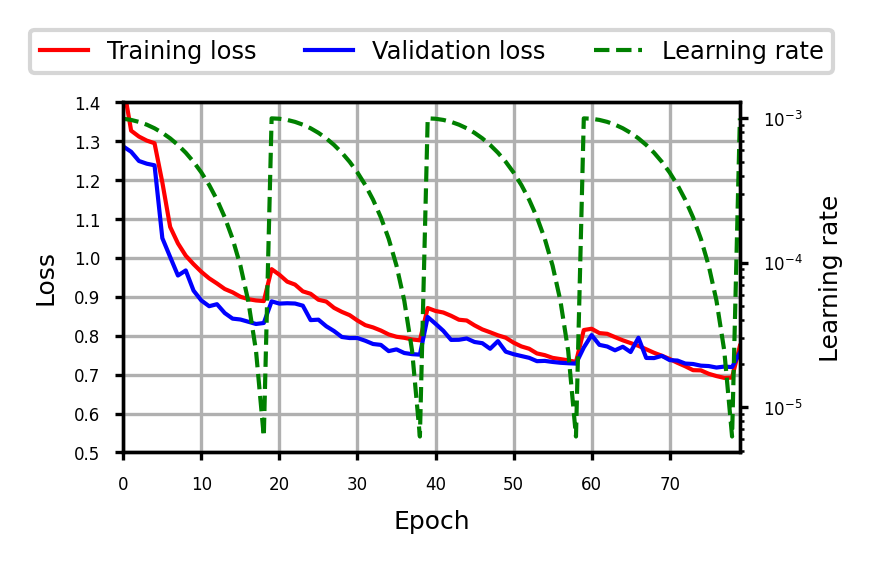

In [8]:
module0 = CNNClassifierModule(
    model=CNNClassifier.from_timm(**cfg_model),
    cfg_training=cfg_training_a0
    )

cb_a0 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b0 = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=cfg_training_b0.get("patience_es")
    )
cb_c0 = LearningRateMonitor(logging_interval="epoch")
logger0 = CSVLogger(save_dir="logs/", name="run01", flush_logs_every_n_steps=1)

trainer0 = pl.Trainer(
    max_epochs=cfg_training_b0.get("epochs"),
    check_val_every_n_epoch=1,
    callbacks=[cb_a0, cb_b0, cb_c0],
    logger=logger0,
    accelerator=device,
    enable_progress_bar=True
    )
trainer0.fit(
    model=module0,
    train_dataloaders=loader_train0,
    val_dataloaders=loader_val
    )


def display_training_progress(trainer, y_lim, figsize=(3, 2)):
    logs = pd.read_csv(Path(trainer.logger.log_dir + "/metrics.csv"))
    epochs = logs.dropna(subset=["train_loss"])["epoch"]

    fig, ax0 = plt.subplots(figsize=figsize)
    l0 = ax0.plot(epochs, logs["train_loss"].dropna(), color="r",
                  label="Training loss")
    l1 = ax0.plot(epochs, logs["val_loss"].dropna(), color="b",
                  label="Validation loss")
    ax0.set_xlabel("Epoch")
    ax0.set_ylabel("Loss")
    ax0.set_xlim(0, len(epochs)-1)

    ax1 = ax0.twinx()
    l2 = ax1.plot(
        epochs, logs["lr-Adam"].dropna(), color="g", linestyle="dashed",
        label="Learning rate")
    ax1.set_ylabel("Learning rate")
    ax1.set_yscale("log")
    ax0.set_ylim(y_lim[0], y_lim[1])
    ax0.legend(l0+l1+l2, [l.get_label() for l in l0+l1+l2], loc="lower center",
               bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)
    plt.tight_layout()
    ax0.grid()
    plt.show()


display_training_progress(trainer0, [0.5, 1.4])

Saving the MC-dropout model (& backbone):

In [9]:
checkpoint_file0 = trainer0.checkpoint_callback.best_model_path
module0_best = CNNClassifierModule.load_from_checkpoint(
    checkpoint_file0,
    model=CNNClassifier.from_timm(**cfg_model),
    cfg_training=cfg_training_a0
    )

model_best0 = module0_best.model
_ = model_best0.eval()
torch.save(model_best0, "./drive/MyDrive/model_best0.pt")

bb_best0 = module0_best.model.bb
_ = bb_best0.eval()
torch.save(bb_best0, "./drive/MyDrive/bb_best0.pt")

Freezing backbone


Inference for the MC-dropout model:

In [10]:
model_best0 = torch.load(
    "./drive/MyDrive/model_best0.pt", map_location=device, weights_only=False)
_ = model_best0.eval()

ds_test = CustomDataset(X_test, y_test, dic_cls, transforms_val)
loader_test = DataLoader(
    dataset=ds_test,
    batch_size=cfg_training_a0.get("batch_size"),
    shuffle=False,
    num_workers=2,
    pin_memory=True if device == "cuda" else False
    )

y_test_pred0 = torch.zeros(
    (n_mc_reps, len(ds_test), len(dic_cls)),
    dtype=torch.float32
    )
with torch.no_grad():
    for idx in range(n_mc_reps):
        tmp = []
        for batch_idx, (img_batch, y_batch) in enumerate(loader_test):
            img_batch = img_batch.to(device)
            y_pred_batch = F.softmax(model_best0(img_batch), dim=1)
            tmp.append(y_pred_batch)

        y_test_pred0[idx, :, :] = torch.cat(tmp, axis=0)

y_test_pred_mean0 = torch.mean(y_test_pred0, axis=0)
y_test_pred_hard0 = y_test_pred_mean0.argmax(1)

Let's calculate a few metrics for the MC-dropout model:

In [11]:
def metrics_per_class(y_true, y_pred, dic_cls):
    cm = confusion_matrix(y_true, y_pred).astype(np.float32)
    acc_per_class = np.zeros((len(dic_cls),), dtype=np.float32)
    fpr_per_class = np.zeros((len(dic_cls),), dtype=np.float32)

    for idx in range(len(dic_cls)):
        tp = cm[idx, idx]
        fp = cm[:, idx].sum() - tp
        fn = cm[idx, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        acc_per_class[idx] = (tp + tn) / (tp + tn + fp + fn)

        fpr_per_class[idx] = np.divide(fp, (fp + tn), out=np.zeros_like(fp), where=(fp + tn)!=0)
    return acc_per_class.round(3), fpr_per_class.round(3)

nll0 = -torch.log(
    y_test_pred_mean0[
        torch.arange(y_test.shape[0]),
        torch.from_numpy(y_test).flatten().long()
        ]
    ).mean().cpu().numpy()

y_test_pred_mean0 = y_test_pred_mean0.cpu().numpy()
y_test_pred_hard0 = y_test_pred_hard0.cpu().numpy()

accuracy0 = accuracy_score(y_test.flatten(), y_test_pred_hard0)
acc_per_class0, _ = metrics_per_class(
    y_test.flatten(), y_test_pred_hard0, dic_cls)

print(f"Accuracy: {accuracy0:.3f}")
print(f"Accuracy per class: {acc_per_class0}")
print(f"NLL: {nll0:.3f}")

Accuracy: 0.744
Accuracy per class: [0.886 0.961 0.971 0.944 0.949 0.962 0.899 0.918]
NLL: 0.719


Let's clear memory first.

In [12]:
del module0
del trainer0
del module0_best
del bb_best0

if device == "cuda":
	  torch.cuda.empty_cache()

gc.collect()

12894

Let's train the VBBL model and display training progress:

Freezing backbone


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model │ CNNClassifierVBBL │ 16.4 M │ train │     0 │
└───┴───────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 5.3 M                                                                                            
Non-trainable params: 11.2 M                                                                                       
Total params: 16.4 M                                                                                               
Total estimated model params size (MB): 65                                                                         
Modules in train mode: 14                                                                                          
Modules in eval mode: 90                                                                                           
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:534: Found 90 module(s) in eval mode at
the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore
this warning.

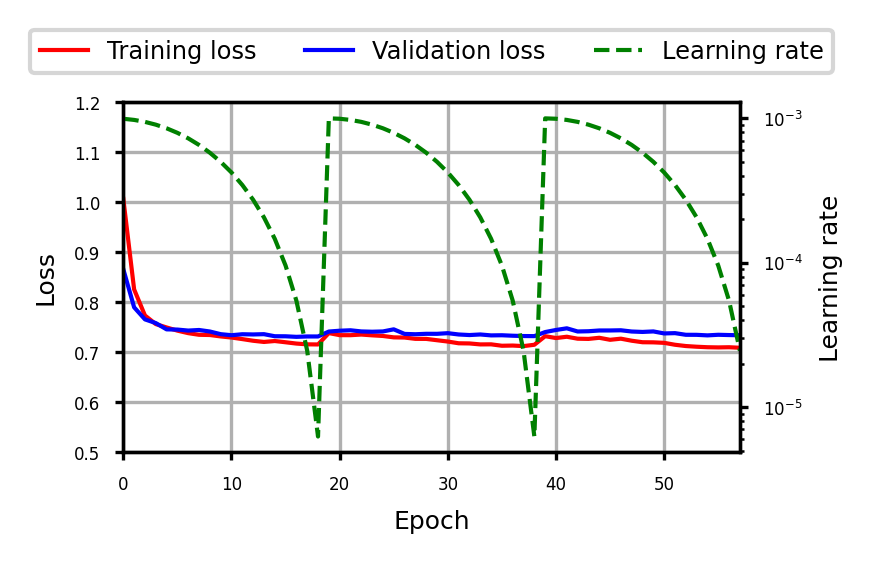

In [13]:
cfg_training_a1 = deepcopy(cfg_training_a0)
cfg_training_b1 = deepcopy(cfg_training_b0)
cfg_training_a1["epoch_unfreeze_bb"] = 1000 # freeze backbone throughout whole training process
cfg_training_a1["batch_size"] = 128 # decrease memory footprint
cfg_training_b1["epochs"] = 80
del cfg_model["mc_dropout"]

loader_train1 = DataLoader(
    dataset=ds_train,
    batch_size=cfg_training_a1.get("batch_size"),
    sampler=sampler_train0,
    num_workers=2,
    pin_memory=True if device == "cuda" else False
    )

module1 = CNNClassifierModuleVBBL(
    model=CNNClassifierVBBL.from_pt(
        fp="./drive/MyDrive/bb_best0.pt",
        p_dropout=cfg_model.get("p_dropout"),
        n_cls=cfg_model.get("n_cls"),
        device=device,
        len_ds_train=len(ds_train)
        ),
    cfg_training=cfg_training_a1
    )

cb_a1 = ModelCheckpoint(monitor="val_loss", mode="min")
cb_b1 = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=cfg_training_b1.get("patience_es")
    )
cb_c1 = LearningRateMonitor(logging_interval="epoch")
logger1 = CSVLogger(save_dir="logs/", name="run02", flush_logs_every_n_steps=1)

trainer1 = pl.Trainer(
    max_epochs=cfg_training_b1.get("epochs"),
    check_val_every_n_epoch=1,
    callbacks=[cb_a1, cb_b1, cb_c1],
    logger=logger1,
    # precision="16-mixed",
    accelerator=device,
    enable_progress_bar=True
    )
trainer1.fit(
    model=module1,
    train_dataloaders=loader_train1,
    val_dataloaders=loader_val
    )

display_training_progress(trainer1, [0.5, 1.2])

Saving the VBBL model:

In [14]:
checkpoint_file1 = trainer1.checkpoint_callback.best_model_path
module1_best = CNNClassifierModuleVBBL.load_from_checkpoint(
    checkpoint_file1,
    model=CNNClassifierVBBL.from_timm(len_ds_train=len(ds_train), **cfg_model),
    cfg_training=cfg_training_a1
    )

model_best1 = module1_best.model
_ = model_best1.eval()
torch.save(model_best1, "./drive/MyDrive/model_best1.pt")

Freezing backbone


Inference for the VBBL model:

In [15]:
model_best1 = torch.load(
    "./drive/MyDrive/model_best1.pt", map_location=device, weights_only=False)
_ = model_best1.eval()

with torch.no_grad():
    tmp0, tmp1 = [], []
    for batch_idx, (img_batch, y_batch) in enumerate(loader_test):
        img_batch = img_batch.to(device)
        out_batch = model_best1(img_batch)
        tmp0.append(out_batch.predictive.probs)
        tmp1.append(out_batch.predictive.entropy())

    y_test_pred_mean1 = torch.cat(tmp0, axis=0)
    entropies = torch.cat(tmp1)

y_test_pred_hard1 = y_test_pred_mean1.argmax(1)

Let's calculate a few metrics for the VBBL model:

In [16]:
entropies = entropies.cpu().numpy()
nll1 = -torch.log(
    y_test_pred_mean1[
        torch.arange(y_test.shape[0]),
        torch.from_numpy(y_test).flatten().long()
        ]
    ).mean().cpu().numpy()

y_test_pred_mean1 = y_test_pred_mean1.cpu().numpy()
y_test_pred_hard1 = y_test_pred_hard1.cpu().numpy()

accuracy1 = accuracy_score(y_test.flatten(), y_test_pred_hard1)
acc_per_class1, _ = metrics_per_class(
    y_test.flatten(), y_test_pred_hard1, dic_cls)

print(f"Accuracy: {accuracy1:.3f}")
print(f"Accuracy per class: {acc_per_class1}")
print(f"NLL: {nll1:.3f}")

Accuracy: 0.745
Accuracy per class: [0.885 0.962 0.97  0.945 0.951 0.961 0.898 0.918]
NLL: 0.718


Let's do the head-to-head comparision of the MC-dropout model vs the VBBL model:

In [17]:
print("Direct comparision: MC-dropout vs VBBL")
print(f"Accuracy: {accuracy0:.3f} vs {accuracy1:.3f}")
print(f"NLL: {nll0:.3f} vs {nll1:.3f}")

Direct comparision: MC-dropout vs VBBL
Accuracy: 0.744 vs 0.745
NLL: 0.719 vs 0.718


Accuracy is insignificantly impacted by the introduction of VBBL. Yet at the same time, the VBBL model also does not seem to output predicted propabilities that are better calibrated, as measured by NLL.

Let's check if entropy (as a measure of uncertainty) for the VBBL model is lower for correct classifications than it is for misclassifications:

In [18]:
idx_correct = np.where(y_test.flatten() == y_test_pred_hard1)[0]
idx_incorrect = np.where(y_test.flatten() != y_test_pred_hard1)[0]

print(f"Entropy of correct vs misclassifications: {np.mean(entropies[idx_correct]):.3f} vs {np.mean(entropies[idx_incorrect]):.3f}")

Entropy of correct vs misclassifications: 0.518 vs 1.020
